# Oven flux analysis

Analyze the flux leaving our oven. This is to resovle a discrepancy in the observed versusu predicted flux. Basically the last culprit is maybe the oven doesn't spit out what we think it does

## overlap integral

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#run 16 and 18 are from 1_20_2022
#others are from 1_27_2022

runName='run20'
atomicBeamRadiusDict={'run18':5e-3,'run16':7.5e-3,'run20':5e-3,'run21':5e-3,'run22':5e-3,'run23':5e-3,'run62':5e-3,'run58':5e-3}
#really rough guess for run16. FOr others I assume they are the same as run18 because the laser is in the same place
#beacuse it appears to be so
powerDict={'run18':19.8e-6,'run16':19.8e-6,'run20':5.9e-6,'run21':6.0e-6,'run22':2.38e-6,'run23':2.7e-6,'run62':2.1e-6,'run58':2.8e-6}
windowFactor=.93 #horizontal beam goes through 1 window
P=windowFactor*powerDict[runName]
w=3.0e-3 #meters
I0=(2*P/(np.pi*w**2))
atomicBeamRadius=atomicBeamRadiusDict[runName] #meter
pixelSize=.147e-3 #meter
xBounds=(-1.5*pixelSize,1.5*pixelSize) #longitudinal
yBounds=(-atomicBeamRadius,atomicBeamRadius) #in and out of image
zBounds=xBounds #vertical image
IFunc=lambda y,z:np.exp(-2*(y**2+z**2)/w**2)
yArr=np.linspace(yBounds[0],yBounds[1],100)
zArr=np.linspace(zBounds[0],zBounds[1],100)
dA=(yArr[1]-yArr[0])*(zArr[1]-zArr[0])
coords=np.asarray(np.meshgrid(yArr,zArr)).T.reshape(-1,2)
integral=sum([IFunc(*coord)*dA for coord in coords])
overlapIntegral=integral*(xBounds[1]-xBounds[0])
print('unitless overlap integral: ',overlapIntegral)


unitless overlap integral:  7.353607183617871e-10


In [2]:
#test that my overlap integral makes sense
yArrTest=np.linspace(-3*w,3*w,300)
zArrTest=np.linspace(-3*w,3*w,300)
dA=(yArrTest[1]-yArrTest[0])*(zArrTest[1]-zArrTest[0])
coords=np.asarray(np.meshgrid(yArrTest,zArrTest)).T.reshape(-1,2)
powerTest=I0*sum([IFunc(*coord)*dA for coord in coords])
assert abs(powerTest-P)<P/1e6

## import fits file data and DAQ data. Make frequency array

In [3]:
#-----import data and orient------
from astropy.io import fits
filePath='data/'
fitsFile=fits.open(filePath+runName+'Near.fits')
imagesArrRaw=fitsFile[0].data
imagesArrRaw=imagesArrRaw.astype(float) #need to convert to float from int16
imagesArrRaw=np.flip(imagesArrRaw,axis=1)
assert len(imagesArrRaw.shape)==3

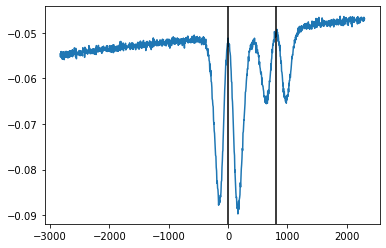

In [4]:
voltZeroFreqDict={'run18':-1.01,'run16':-1.01,'run20':.465,'run21':.465,'run22':.485,'run23':.5,'run62':.625,'run58':.625}
daqData=np.loadtxt(filePath+runName+'DAQData.csv',delimiter=',') #everything looks good and agrees
voltArrTotal=daqData[:,0]
scanRangeDict={'run18':(-3.9,3.9),'run16':(-3.9,3.9),'run20':(-4.4,4.4),'run21':(-4.4,4.4),'run22':(-4.4,4.4),'run23':(-4.4,4.4),'run62':(-4.4,4.4),'run58':(-4.4,4.4)}
# %matplotlib tk
# plt.plot(daqData[:,0],daqData[:,1])
# plt.show()
# %matplotlib inline
voltZeroFreq=voltZeroFreqDict[runName] #from the graph
scanStart,scanStop=scanRangeDict[runName]
assert scanStart>daqData[:,0].min() and scanStop<daqData[:,0].max()
HzPerVolt=570.0*1e6
voltArr=np.linspace(scanStart,scanStop,len(imagesArrRaw))
freqArrRaw=(voltArr-voltZeroFreq)*HzPerVolt
freqArrTotal=(voltArrTotal-voltZeroFreq)*HzPerVolt
plt.plot(freqArrTotal/1e6,daqData[:,1])
plt.axvline(x=0.0,c='black')
plt.axvline(x=804.0,c='black')
plt.show()

In [5]:
#we have no dark image so I have to get the background by inspection
backgroundValue=imagesArrRaw.min()
imagesArr=imagesArrRaw-backgroundValue

### make sure I am faithfully extracting the same image here that I am on the fits file

There are some wierd image I need to trim away present in all the first few images. Or at least I think they are weird....

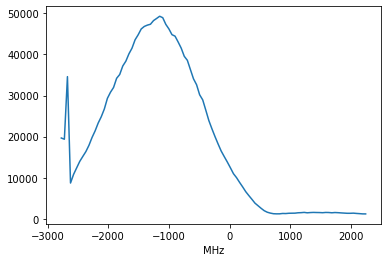

In [6]:
#I'm not totally sure that the image region is exactly the same. At most it's off by 1 pixel
#x: longitudinal
#y: in and out of image
#z: vertical
subImageFitCoordsDict={'run18':[[226,228],[169,171]],'run16':[[308,310],[291,293]],'run20':[[214,216],[159,161]],
        'run21':[[214,216],[159,161]],'run22':[[214,216],[159,161]],'run23':[[214,216],[159,161]],
                       'run62':[[208,210],[155,157]],'run58':[[208,210],[155,157]]} #counted at center of pixel
subImageCoords=subImageFitCoordsDict[runName]

assert imagesArr.min()>=0.0
totalPixelsZ=imagesArr.shape[1]
xPixelsFit=np.asarray(subImageCoords[0])-1
zPixelsFit=np.asarray(subImageCoords[1])
xPixelNP=xPixelsFit
zPixelNP=totalPixelsZ-np.flip(zPixelsFit)
xPixelNP[1]+=1
zPixelNP[1]+=1
subImage=imagesArr[:,zPixelNP[0]:zPixelNP[1],xPixelNP[0]:xPixelNP[1]]
spectralProfileFull=np.sum(np.sum(subImage,axis=1),axis=1)
plt.plot(freqArrRaw/1e6,spectralProfileFull)
plt.xlabel('MHz')
plt.show()

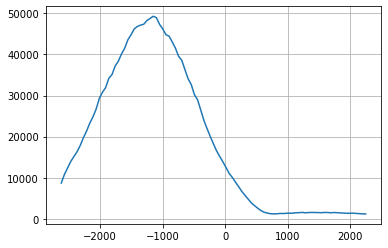

In [7]:
weirdImagesDict={'run18':4,'run16':4,'run20':3,'run21':3,'run22':3,'run23':3,'run62':3,'run58':3}
weirdImages=weirdImagesDict[runName]
spectralProfile=spectralProfileFull[weirdImages:]
freqArr=freqArrRaw[weirdImages :]
plt.plot(freqArr/1e6,spectralProfile)
plt.grid()
plt.show()

## Fit the data to a gaussian profile to determine temperature and the peak of the normalized spectral profile

In [8]:
angle=np.pi/4
lam=670.776e-9
def deltaFreqToVelocity(deltaFreq,angle):
    return -deltaFreq*lam/np.cos(angle)

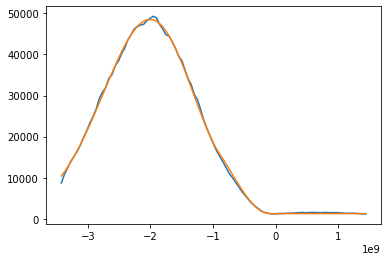

Temp is: 654.8159546649089
estimated angle is: 45.121644851027604 degree
peak speed 1907.3501909369777


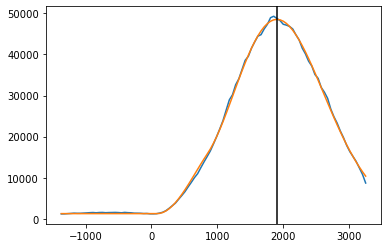

In [9]:
#fit the data to a temperautre profile
#ALL I AM TRYING TO DO IS FIND THE TEMPERATURE. be cautious using other results



import scipy.optimize as spo
kb=1.38e-23
m=1.16e-26
hyperfineSep=804e6
#run 16 and 18 have the sidebands on
#tuples ratio values are (F2,F1)
peakWeightDict={'run18':(1.18,.9),'run16':(1.18,.9),'run20':(1.,0.6),'run21':(1.0,.6),'run22':(1.0,.6),'run23':(1.0,.6),'run62':(1.0,.6),'run58':(1.0,.6) }
peakWeights=peakWeightDict[runName]
freqToVelocity=671e-9 #turn out this is the doppler shift
ovenTiltAngle=45*np.pi/180 #tilt of oven
theta=5*np.pi/180 #angle from centerline of oven. must be small angle
@np.vectorize
def maxwell_Boltzman_Speed(s,T):
    if s<0:
        return 0.0
    sigma_T=np.sqrt(kb*T/m) # m/s
    sMean=np.sqrt(np.pi*kb*T/(2*m)) #to normalize
    return s**2*np.exp(-.5*s**2/sigma_T**2)/sMean**2
def spectral_Profile_Func(freq,freq0,a,b,T,tilt):
    vT1=deltaFreqToVelocity(freq-freq0,tilt)
    vT2=deltaFreqToVelocity(freq-freq0-hyperfineSep,tilt)
    normSignal=a*peakWeights[0]*maxwell_Boltzman_Speed(vT1,T)
    normSignal+=a*peakWeights[1]*maxwell_Boltzman_Speed(vT2,T)
    return normSignal+b
freqArrFit=freqArr-hyperfineSep
minAngle=40*np.pi/180
maxAngle=55*np.pi/180
bounds=[(-np.inf,0.0,-np.inf,100.0,minAngle),(np.inf,np.inf,np.inf,np.inf,maxAngle)]
guess=[-1e8,spectralProfile.max(),0.0,800.0,np.pi/4]
params=spo.curve_fit(spectral_Profile_Func,freqArrFit,spectralProfile,p0=guess,bounds=bounds)[0]
v=deltaFreqToVelocity(freqArrFit,params[-1])

plt.plot(freqArrFit,spectralProfile)
plt.plot(freqArrFit,spectral_Profile_Func(freqArrFit,*params))
plt.show()
peakVelocity=v[np.argmax(spectral_Profile_Func(freqArrFit,*params))]
print('Temp is:',params[3])
print('estimated angle is:',180*params[-1]/np.pi,'degree')
print('peak speed',peakVelocity)
plt.plot(v,spectralProfile)
plt.plot(v,spectral_Profile_Func(freqArrFit,*params))
plt.axvline(x=peakVelocity,c='black')
plt.show()


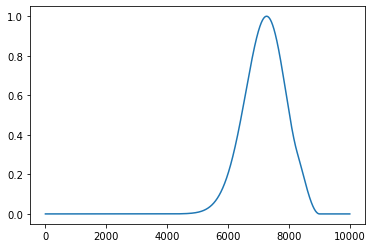

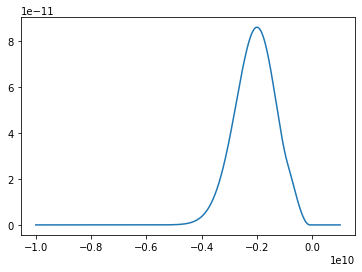

8.582786316043162e-11

In [10]:
#in radians per second
#get the area from the above fit
freqArrIntegral=np.linspace(-10_000,1000,10_000)*1e6
freq0,height,offset,T,tilt=params
offset=0.0
spectralProfileIntegral=spectral_Profile_Func(freqArrIntegral,freq0,height,offset,T,tilt)
spectralProfileIntegral=spectralProfileIntegral/spectralProfileIntegral.max()
plt.plot(spectralProfileIntegral)
plt.show()
assert spectralProfileIntegral[0]<spectralProfileIntegral.max()/1e6 and spectralProfileIntegral[-1]<spectralProfileIntegral.max()/1e6
freqArrRadians=2*np.pi*freqArrIntegral
spectralProfileNumericArea=np.trapz(spectralProfileIntegral,x=freqArrRadians)
spectralProfileNormalized=spectralProfileIntegral/spectralProfileNumericArea
plt.plot(freqArrIntegral,spectralProfileNormalized)
plt.show()
peakSpectralNorm=spectralProfileNormalized.max()
#
peakSpectralNorm #4.660541299762652e-11

## misc constants and camera/optics conversion

In [11]:
#--------- sigma0 -----------
alignmentFactor=3
transitionStrength=.5
A21=3.689E7 #einstein coefficient
lam=671e-9
sigma0=transitionStrength*alignmentFactor*A21*lam**2/4.0 #this is defined for when the spectral profile is normalized using radians/second
print('sigma0: ',sigma0,'m')

sigma0:  6.22852143375e-06 m


In [12]:
#--counts to scattering rate----
countsToScattering=7416.0 #from jeremy. I have not double checked

#----other constants---
lam=671e-9
h=6.626e-34
freqTransition=3e8/lam

In [13]:
scattering=spectralProfile.max()*countsToScattering
term1=I0*sigma0*peakSpectralNorm*overlapIntegral/(h*freqTransition)
peakDensity=scattering/term1 #units of atoms/m^3
#run 18
scattering/1e6 #365.705208

365.705208

In [14]:
#get the total flux, Need to integrate the velocity probability distribution weighted by the velocity and the density over the are in question.
#since the density is assumed to be constant over the area of interest, that can come out of the integral


atomBeamArea=np.pi*(atomicBeamRadius**2)
areaDensity=atomBeamArea*peakDensity
flux=areaDensity*peakVelocity
print('flux',np.round(flux/1e12),' 1e12')

flux 106.0  1e12


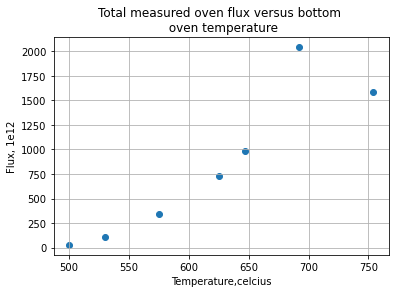

In [15]:
T=np.asarray([500,530.0,575,625,647,692,754])
Flux=np.asarray([27.5,106,345,730,988,2040,1589])
plt.scatter(T,Flux)
plt.title('Total measured oven flux versus bottom \n oven temperature')
plt.ylabel('Flux, 1e12')
plt.xlabel('Temperature,celcius')
plt.grid()
plt.show()